In [696]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [697]:
import tensorflow as tf  

In [698]:
#pip list

In [699]:
data  = pd.read_csv('anti-bully-data copy 5.csv')

In [700]:
data

,label_bullying,text_message
0,0,yeah I got 2 backups for all that. I just hate...
1,0,I hate using my BB but love my iPhone. Haven'...
2,1,Get fucking real dude. and dont be a fool
3,1,She is as dirty as they come and that crook ...
4,1,why did you fuck it up. I could do it all day...
...,...,...
8823,0,no caffiene would kick my ass too - I'm addict...
8824,0,Now I'm hungry. Damn you people and your midn...
8825,0,i've taken one also. people just piss me off m...
8826,0,That too! Or even being able to park pulling ...


In [701]:
data['label_bullying'].unique()

array([0, 1], dtype=int64)

In [702]:
data[data['label_bullying']==1].shape

(5075, 2)

In [703]:
data[data['label_bullying']==0].shape

(3753, 2)

In [704]:
data =data.dropna()

In [705]:
data 

,label_bullying,text_message
0,0,yeah I got 2 backups for all that. I just hate...
1,0,I hate using my BB but love my iPhone. Haven'...
2,1,Get fucking real dude. and dont be a fool
3,1,She is as dirty as they come and that crook ...
4,1,why did you fuck it up. I could do it all day...
...,...,...
8823,0,no caffiene would kick my ass too - I'm addict...
8824,0,Now I'm hungry. Damn you people and your midn...
8825,0,i've taken one also. people just piss me off m...
8826,0,That too! Or even being able to park pulling ...


In [706]:
data['text_message'].unique()

array(['yeah I got 2 backups for all that. I just hate when that happen. I been strugglin for a week now...handle that tho',
       "I hate using my BB  but love my iPhone. Haven't tried the new BB. My BB is provided by my corp. I don't get to pick which model",
       ' Get fucking real dude. and dont be a fool', ...,
       "i've taken one also. people just piss me off more & more recently",
       'That  too! Or even being able to park pulling in forward rather than backwards--I hate when the car behind me pulls up and BLOCKS!',
       ". . . HE'S FUCKING HIMSELF!"], dtype=object)

In [707]:
data = data[['text_message','label_bullying']]

In [708]:
data['text_message'] = data['text_message'].apply(lambda x: x.lower())
data['text_message'] = data['text_message'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [709]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text_message'].values)
X = tokenizer.texts_to_sequences(data['text_message'].values)
X = pad_sequences(X)



In [710]:
# ===== Statistical Preprocessing Step (Stand-Alone) =====
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Create a numeric feature: sequence lengths (non-zero token count)
seq_lengths = np.array([len([t for t in seq if t != 0]) for seq in X]).reshape(-1, 1)

# Apply Min–Max scaling to this numeric feature
scaler = MinMaxScaler()
seq_lengths_scaled = scaler.fit_transform(seq_lengths)

# Optional: view before & after
print("Original lengths (first 10):", seq_lengths[:10].flatten())
print("Scaled lengths (first 10):", seq_lengths_scaled[:10].flatten())


Original lengths (first 10): [20 26  9 24 30 21 15 21 23 10]
Scaled lengths (first 10): [0.45454545 0.59090909 0.20454545 0.54545455 0.68181818 0.47727273
 0.34090909 0.47727273 0.52272727 0.22727273]


In [711]:
X

array([[   0,    0,    0, ...,  286,    6,  395],
       [   0,    0,    0, ...,  651,  348, 1989],
       [   0,    0,    0, ...,   26,    4,   42],
       ...,
       [   0,    0,    0, ...,   87,   87, 1039],
       [   0,    0,    0, ...,   41,    8, 1297],
       [   0,    0,    0, ...,  177,   34, 1230]])

In [712]:
embed_dim = 100
lstm_out = 126

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 44, 100)           200000    
                                                                 
 spatial_dropout1d_18 (Spati  (None, 44, 100)          0         
 alDropout1D)                                                    
                                                                 
 lstm_18 (LSTM)              (None, 126)               114408    
                                                                 
 dense_18 (Dense)            (None, 2)                 254       
                                                                 
Total params: 314,662
Trainable params: 314,662
Non-trainable params: 0
_________________________________________________________________
None


In [713]:
Y = pd.get_dummies(data['label_bullying']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6179, 44) (6179, 2)
(2649, 44) (2649, 2)


In [714]:
batch_size = 10
model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2)

Epoch 1/20
618/618 - 40s - loss: 0.5228 - accuracy: 0.7124 - 40s/epoch - 65ms/step
Epoch 2/20
618/618 - 69s - loss: 0.4331 - accuracy: 0.7742 - 69s/epoch - 111ms/step
Epoch 3/20
618/618 - 64s - loss: 0.3886 - accuracy: 0.8110 - 64s/epoch - 104ms/step
Epoch 4/20
618/618 - 54s - loss: 0.3497 - accuracy: 0.8362 - 54s/epoch - 87ms/step
Epoch 5/20
618/618 - 53s - loss: 0.3121 - accuracy: 0.8552 - 53s/epoch - 86ms/step
Epoch 6/20
618/618 - 44s - loss: 0.2790 - accuracy: 0.8726 - 44s/epoch - 72ms/step
Epoch 7/20
618/618 - 48s - loss: 0.2486 - accuracy: 0.8899 - 48s/epoch - 77ms/step
Epoch 8/20
618/618 - 56s - loss: 0.2229 - accuracy: 0.9034 - 56s/epoch - 91ms/step
Epoch 9/20
618/618 - 57s - loss: 0.1981 - accuracy: 0.9128 - 57s/epoch - 92ms/step
Epoch 10/20
618/618 - 53s - loss: 0.1706 - accuracy: 0.9230 - 53s/epoch - 86ms/step
Epoch 11/20
618/618 - 65s - loss: 0.1538 - accuracy: 0.9311 - 65s/epoch - 106ms/step
Epoch 12/20
618/618 - 55s - loss: 0.1464 - accuracy: 0.9372 - 55s/epoch - 88ms/ste

In [715]:

y_test_arg=np.argmax(Y_test,axis=1)
Y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')

83/83 [==============================] - 2s 17ms/step
Confusion Matrix


In [716]:
import sklearn.metrics

In [717]:
print(sklearn.metrics.classification_report(y_test_arg, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.61      0.64      1149
           1       0.72      0.77      0.75      1500

    accuracy                           0.70      2649
   macro avg       0.70      0.69      0.70      2649
weighted avg       0.70      0.70      0.70      2649



In [718]:
from sklearn.metrics import confusion_matrix

In [719]:
print(confusion_matrix(y_test_arg, Y_pred))

[[ 706  443]
 [ 341 1159]]


In [720]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_arg, Y_pred)
cm


array([[ 706,  443],
       [ 341, 1159]], dtype=int64)

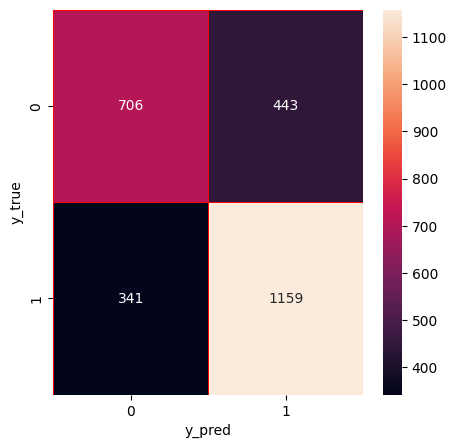

In [721]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [722]:
import pickle

In [723]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [724]:
model.save('lstms.h5')

In [725]:
twt = ["Hello Beautiful"]
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)

In [726]:
print(twt)

[[918]]


In [727]:
print(twt)

[[918]]


In [728]:
twt = pad_sequences(twt, maxlen=30, dtype='int32', value=0)
print(twt)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
print(sentiment)
if(np.argmax(sentiment) == 1):
    print("bullying")
elif (np.argmax(sentiment) == 0):
    print("No_bullying")

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0 918]]
1/1 - 0s - 217ms/epoch - 217ms/step
[0.92782956 0.07217047]
No_bullying
